In [1]:
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.dates import DateFormatter
import numpy as np
import os
import pandas as pd

In [2]:
srcdir = f'{os.getcwd()}/pod2_first_experiment/'
colors = ['red', 'blue', 'green', 'cyan']

In [104]:
def open_csv(filename):
    content = pd.read_csv(srcdir + filename, parse_dates=['time'])
    content = content.interpolate(method='linear', limit_direction='both') # replace nan
    return content

class CSVresult:
    def __init__(self):
        self.ids = []
        self.racks = [open_csv(f'sensor_strips_racks_{str(i+1).zfill(2)}_to_{str(i+3).zfill(2)}.csv') for i in range(0, 12, 3)]
        self.coolers = [open_csv(f'cooler_fan_temperature{str(i+1).zfill(2)}.csv') for i in range(0, 4)]
        for i in range(0, 4):
            max_q = 2.18
            df = self.coolers[i]
            dfQ = open_csv(f'cooler_fan_signal{str(i+1).zfill(2)}.csv')
            df.insert(loc=1, column='mass_flow', value=dfQ['signal_default'] / 100 * max_q)
            df.name = f'P02HDZ{str(i+1).zfill(2)}'
        for i in range(0, 12, 3):
            self.racks[int(i/3)].name = f'sensor_strips_racks_{str(i+1).zfill(2)}_to_{str(i+3).zfill(2)}.csv'

    def add(self, results, id):
        self.ids += [id]
        for i in range(0, 4):
            self.coolers[i][f'sim{id}_discharge'] = results[f'P02HDZ{str(i+1).zfill(2)}_out_T']
            self.coolers[i][f'sim{id}_return0'] = results[f'P02HDZ{str(i+1).zfill(2)}_in_T']
            self.coolers[i][f'sim{id}_mass_flow'] = results[f'P02HDZ{str(i+1).zfill(2)}_out_Q']
        for i in range(0, 12, 3):
            self.racks[int(i/3)][f'sim{id}_front_temperature_top'] = results[f'sensors_racks_{str(i+1).zfill(2)}_to_{str(i+3).zfill(2)}_in_t_T']
            self.racks[int(i/3)][f'sim{id}_front_temperature_middle'] = results[f'sensors_racks_{str(i+1).zfill(2)}_to_{str(i+3).zfill(2)}_in_m_T']
            self.racks[int(i/3)][f'sim{id}_front_temperature_bottom'] = results[f'sensors_racks_{str(i+1).zfill(2)}_to_{str(i+3).zfill(2)}_in_b_T']
            self.racks[int(i/3)][f'sim{id}_rear_temperature_top'] = results[f'sensors_racks_{str(i+1).zfill(2)}_to_{str(i+3).zfill(2)}_out_t_T']
            self.racks[int(i/3)][f'sim{id}_rear_temperature_middle'] = results[f'sensors_racks_{str(i+1).zfill(2)}_to_{str(i+3).zfill(2)}_out_m_T']
            self.racks[int(i/3)][f'sim{id}_rear_temperature_bottom'] = results[f'sensors_racks_{str(i+1).zfill(2)}_to_{str(i+3).zfill(2)}_out_b_T']

    def plot_cooler(self, coolerIdx):
        xaxis = 'time'
        yaxis_real = ['mass_flow', 'discharge',
                    'return0']
        yaxes = [yaxis_real]
        for id in self.ids:
            yaxis_sim = [f'sim{id}_mass_flow', f'sim{id}_discharge',
                    f'sim{id}_return0']
            yaxes += [yaxis_sim]
        fig, ax = plt.subplots(3, 1, figsize=(8, 8), sharex=True, sharey=False)
        plt.subplots_adjust(hspace=0)
        for a in ax:
            a.set_ylim((10, 49))
            a.xaxis.set_minor_locator(ticker.AutoMinorLocator())
            a.xaxis.set_major_locator(mdates.HourLocator())
            a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax[0].set_ylim((0, 3))
        ax[0].set_title(self.coolers[coolerIdx].name)
        ax[0].set_ylabel('Flow (m³/s)')
        ax[1].set_ylabel('Discharge (°C)')
        ax[2].set_ylabel('Return (°C)')
        labels = ['Exp.'] + [id for id in self.ids]
        return self.coolers[coolerIdx], xaxis, yaxes, ax, labels

    def plot_rack(self, rackIdx):
        # self.racks[rackIdx]['realpower_sum'] = (self.racks[rackIdx]['realpower_l1'] + self.racks[rackIdx]['realpower_l2'] + self.racks[rackIdx]['realpower_l3']) / 1000
        xaxis = 'time'
        yaxis_real = ['temperature_front_top',#'realpower_sum',
                'temperature_front_top',
                'temperature_front_middle',
                'temperature_front_bottom',
                'temperature_rear_top',
                'temperature_rear_middle',
                'temperature_rear_bottom']
        yaxes = [yaxis_real]
        for id in self.ids:
            yaxis_sim = [f'sim{id}_front_temperature_top',#'realpower_sum',
                    f'sim{id}_front_temperature_top',
                    f'sim{id}_front_temperature_middle',
                    f'sim{id}_front_temperature_bottom',
                    f'sim{id}_rear_temperature_top',
                    f'sim{id}_rear_temperature_middle',
                    f'sim{id}_rear_temperature_bottom']
            yaxes += [yaxis_sim]
        fig, ax = plt.subplots(7, 1, figsize=(8, 16), sharex=True, sharey=False)
        plt.subplots_adjust(hspace=0)
        # if max(self.racks[rackIdx]['realpower_sum']) - min(self.racks[rackIdx]['realpower_sum']) < 0.1:
        #     ax[0].set_ylim((0, 10))
        for a in ax[1:]:
            a.set_ylim((10, 49))
        for a in ax:
            a.xaxis.set_minor_locator(ticker.AutoMinorLocator())
            a.xaxis.set_major_locator(mdates.HourLocator())
            a.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax[0].set_title(self.racks[rackIdx].name)
        ax[0].set_ylabel('Power (kW)')
        ax[1].set_ylabel('Front Top (°C)')
        ax[2].set_ylabel('Front Mid (°C)')
        ax[3].set_ylabel('Front Bottom (°C)')
        ax[4].set_ylabel('Back Top (°C)')
        ax[5].set_ylabel('Back Mid (°C)')
        ax[6].set_ylabel('Back Bottom (°C)')
        labels = ['Exp.'] + [id for id in self.ids]
        return self.racks[rackIdx], xaxis, yaxes, ax, labels

    def get_racks_rmse(self, label):
        measurements = ['front_temperature_top',
                        'front_temperature_middle',
                        'front_temperature_bottom',
                        'rear_temperature_top',
                        'rear_temperature_middle',
                        'rear_temperature_bottom']
        rmse_dicts = []
        for rackId in range(0, 4):
            rmse_dict = {'rack' : f'P02R{str(rackId+1).zfill(2)}'}
            for measurement in measurements:
                prediction = self.racks[rackId][f'sim{label}_{measurement}']
                observation = self.racks[rackId][measurement]
                rmse_dict[measurement] = np.sqrt(np.mean((prediction - observation)**2))
            rmse_dicts += [rmse_dict]
        return pd.DataFrame(rmse_dicts)

In [105]:
# Load simulation data
result = CSVresult()
#result.add(open_csv('output-srt192x177x86.csv'), 'LBM-SRT-192')
result.add(open_csv('output-mrt192x177x86.csv'), 'LBM-MRT-192')

In [83]:
result.racks[1]

,time,temperature_front_bottom,temperature_front_middle,temperature_front_top,temperature_rear_bottom,temperature_rear_middle,temperature_rear_top,simLBM-MRT-192_front_temperature_temp_top,simLBM-MRT-192_front_temperature_temp_middle,simLBM-MRT-192_front_temperature_temp_bottom,simLBM-MRT-192_rear_temperature_temp_top,simLBM-MRT-192_rear_temperature_temp_middle,simLBM-MRT-192_rear_temperature_temp_bottom
0,2019-10-01 08:00:00,19.750,18.340000,24.190,23.690,23.2900,28.130,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,2019-10-01 08:01:00,19.750,18.350000,24.190,23.678,23.2500,28.130,25.1694,22.8713,21.1133,34.3111,33.6012,31.6238
2,2019-10-01 08:02:00,19.735,18.370000,24.220,23.690,23.2625,28.130,26.5638,23.3709,21.3422,36.2930,34.6387,32.4223
3,2019-10-01 08:03:00,19.750,18.360000,24.220,23.750,23.3050,28.116,26.8242,23.5118,21.4602,36.4641,34.8726,32.5245
4,2019-10-01 08:04:00,19.750,18.365000,24.220,23.750,23.3460,28.130,26.7002,23.3970,21.4082,36.4435,34.7928,32.5102
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2019-10-01 17:55:00,18.916,17.896667,24.545,22.940,22.9360,28.130,26.2014,23.0824,21.0584,35.6771,34.1979,31.8873
596,2019-10-01 17:56:00,19.012,17.997500,24.500,23.000,22.9600,28.175,26.6446,23.4435,21.4093,35.8272,34.5867,32.3870
597,2019-10-01 17:57:00,19.060,18.102500,24.500,23.060,23.0000,28.130,26.8460,23.6748,21.6435,36.1698,34.6976,32.7153
598,2019-10-01 17:58:00,19.130,18.146667,24.500,23.145,23.0500,28.175,26.8322,23.7156,21.6683,36.3962,34.4894,32.9888


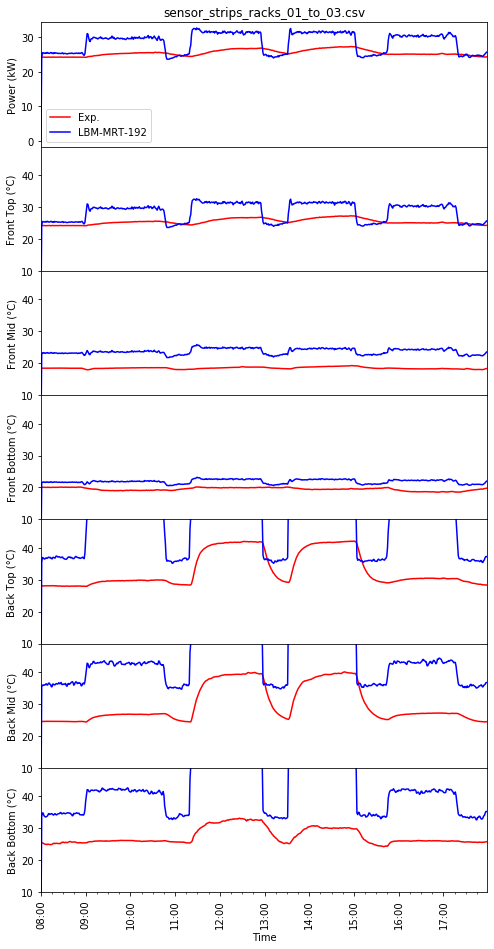

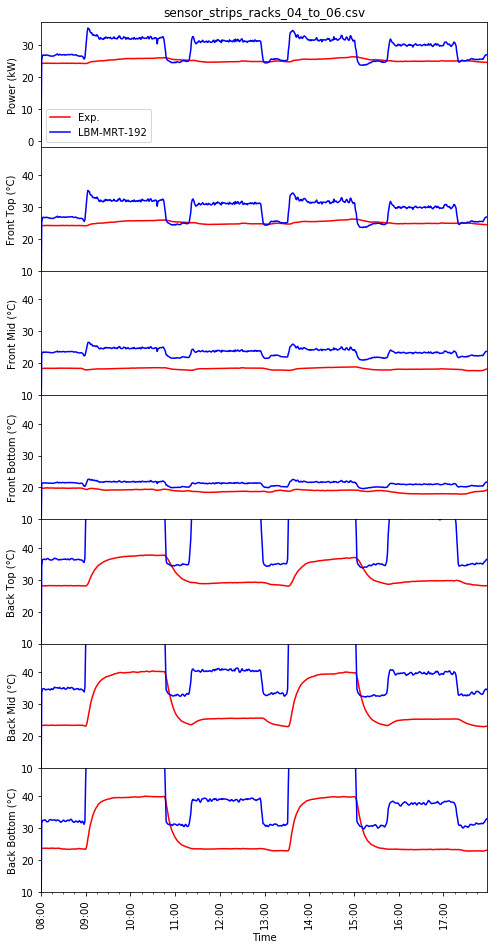

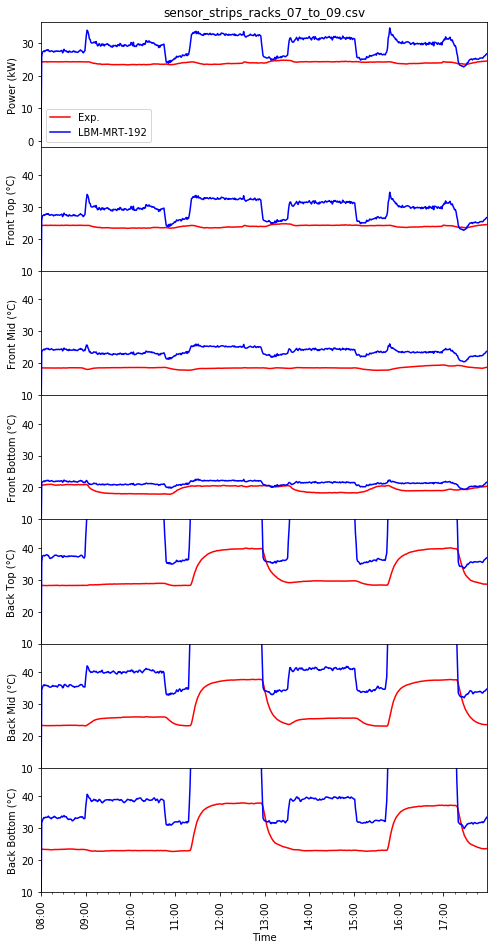

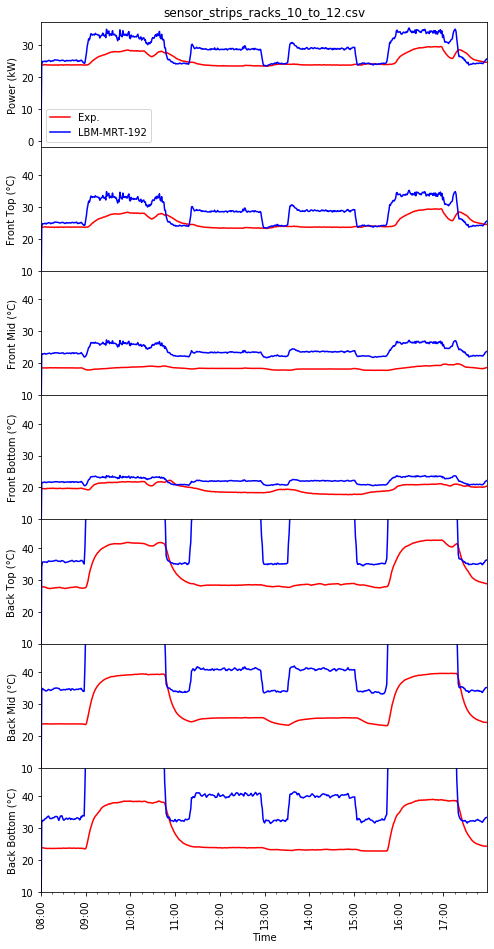

In [107]:
for rackId in range(0, 4):
    rack, xaxis, yaxes, ax, labels = result.plot_rack(rackId)
    for i in range(0, len(yaxes)):
        rack.plot(x=xaxis, y=yaxes[i], ax=ax, rot=90, subplots=True, legend=False, x_compat=True, color=colors[i])
    ax[0].legend(labels=labels)
    ax[-1].set_xlabel('Time')

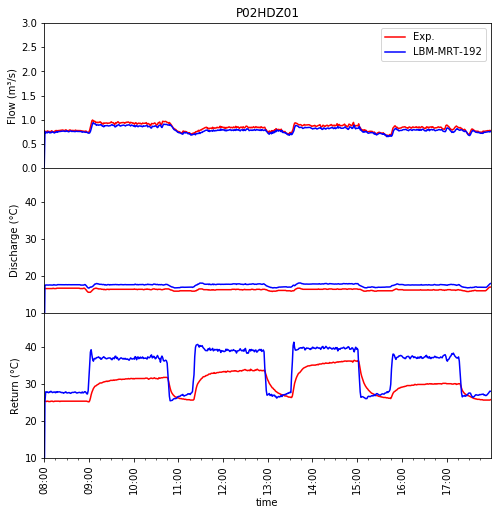

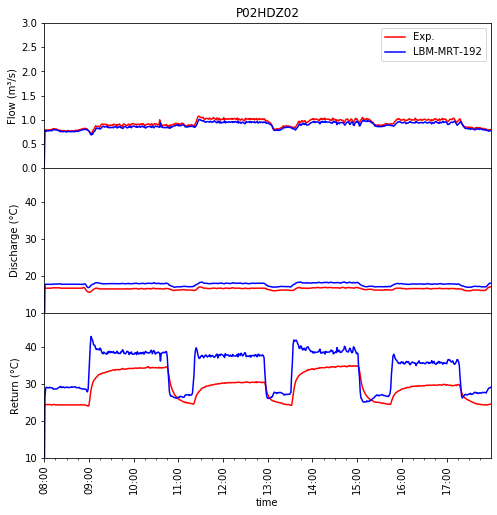

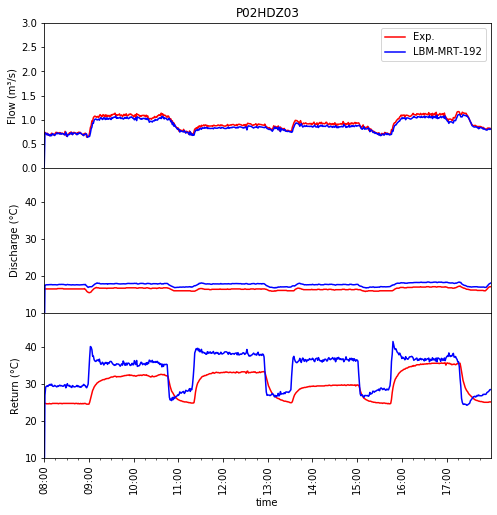

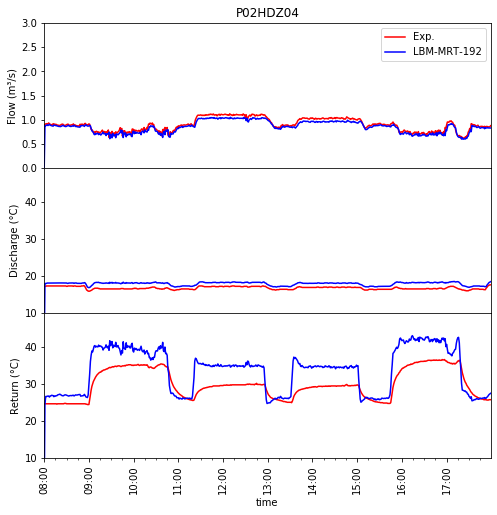

In [53]:
for coolerId in range(0, 4):
    cooler, xaxis, yaxes, ax, labels = result.plot_cooler(coolerId)
    for i in range(0, len(yaxes)):
        cooler.plot(x=xaxis, y=yaxes[i], ax=ax, rot=90, subplots=True, legend=False, x_compat=True, color=colors[i])
    ax[0].legend(labels=labels)
    ax[-1].set_xlabel('Time')

In [5]:
result.get_racks_rmse('LBM-SRT-192')

,rack,front_temperature_temp_top,front_temperature_temp_middle,front_temperature_temp_bottom,rear_temperature_temp_top,rear_temperature_temp_middle,rear_temperature_temp_bottom
0,P02R01,2.274437,3.216557,1.552174,9.200916,2.845488,2.814759
1,P02R02,4.428437,1.831176,1.661783,5.109141,3.493961,3.766635
2,P02R03,4.585851,1.516456,0.827068,4.228413,3.623212,5.632761
3,P02R04,5.742118,1.907101,1.275100,1.473737,1.552577,0.998293
4,P02R05,3.310255,2.198365,1.027978,2.005585,2.440991,2.260841
5,P02R06,1.333260,0.944451,1.119855,5.074529,0.906884,1.227776
6,P02R07,1.300341,1.435373,1.823129,5.541632,2.222969,3.803379
7,P02R08,4.953250,1.378758,2.080263,1.855474,2.096228,2.327350
8,P02R09,5.561252,1.686996,1.841005,1.878153,1.234457,1.621527
9,P02R10,5.160629,3.238317,2.695216,1.300101,3.582081,3.268870


In [6]:
result.get_racks_rmse('LBM-MRT-192')

,rack,front_temperature_temp_top,front_temperature_temp_middle,front_temperature_temp_bottom,rear_temperature_temp_top,rear_temperature_temp_middle,rear_temperature_temp_bottom
0,P02R01,6.772444,1.893095,1.706732,10.223792,5.401959,3.668026
1,P02R02,1.457293,2.270773,2.267727,5.928688,3.149699,2.850624
2,P02R03,4.363616,1.260022,1.258549,8.079366,3.279663,4.992733
3,P02R04,1.486423,0.922107,1.211799,5.375388,3.573472,1.337463
4,P02R05,4.440209,1.206971,1.270390,5.694661,1.659145,0.879157
5,P02R06,9.389339,7.599721,5.040030,10.087973,7.486883,5.099270
6,P02R07,6.534337,3.276319,1.237467,9.728341,3.550645,0.912304
7,P02R08,5.653359,4.572826,2.198138,7.965473,3.488795,2.156249
8,P02R09,0.971146,2.196968,0.760099,6.059849,3.814255,2.343707
9,P02R10,2.938951,2.141518,1.179129,4.826554,1.327631,1.384507
